# Lab 4.2: Target Tracking

In [1]:
%matplotlib widget
import rad.css as css
import rad.example as ex
import rad.quiz as qz
from rad.const import c, k
from rad.radar import to_db, from_db, deg2rad, rad2deg
from math import sqrt, sin, asin, cos, acos, tan, atan2, pi, log, log10
css.add_custom_css()

**Reminders**: 

- Hit the *<font color="DarkBlue">Run All</font>* button <img width="18px" src="img/run_all_icon.png"> button above before continuing
- Useful formulae and definitions are available in [Reference](Reference.ipynb)

In the previous labs, we have looked at how radar systems generate and transmit pulses, receive incoming signals, detect target echoes, and extract target attribute information from a detection. In this lab, we will begin looking at what to do now that we are getting a steady stream of detections from the sensor; more specifically, we will discuss the process subsequent to detection: *tracking*.

<div style="text-align: center"> <img src="img/radar_sys4.png" justify="center" width="700px"></img> </div>

Every time a radar transmits and receives (which can be up to thousands of times per second), it will generate detections. These detections will ideally be created from target echoes but some portion will be false alarms. In the interactive plot below, we can see the raw detections created by a rotating dish radar system (similar to air traffic control radars). In the scene, there is one moving target. As you proceed through the scans, you can watch the target move across the radar display.

GridBox(children=(VBox(children=(HTML(value="<b><font color='black'>Processing</b>"), FloatSlider(value=12.0, …

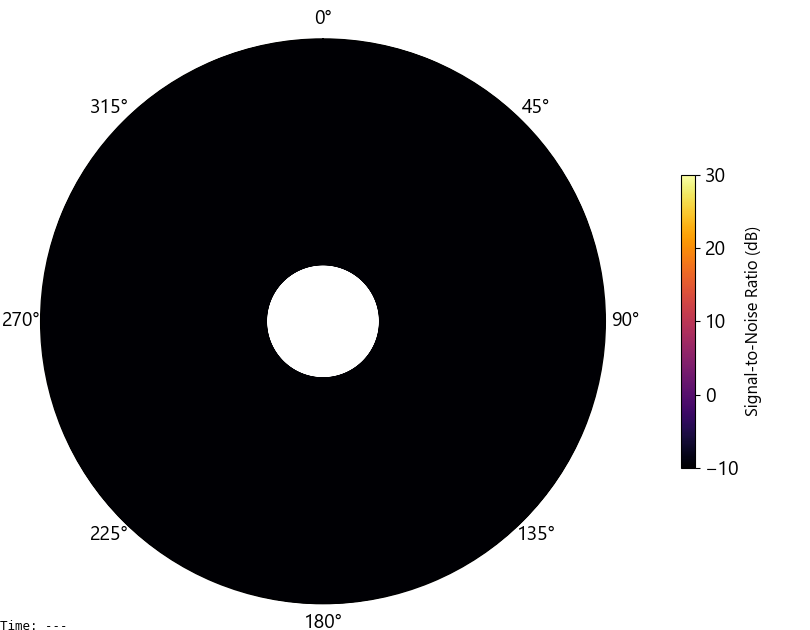

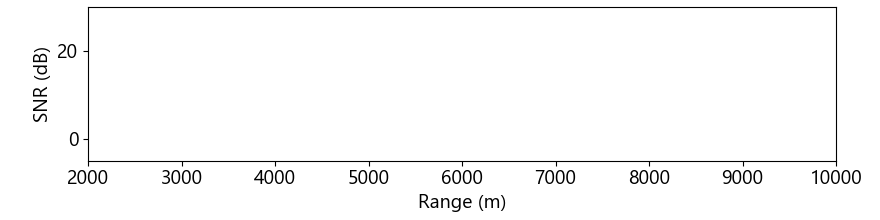

In [2]:
ex.ex_4_2_1()

An important observation from the example above is that detections from the target will follow a continuous path across the radar field of view, whereas false alarms are randomly distributed throughout. This is one of the key ideas that is used to build a **multitarget tracker**, which collects sets of detections over time that are designated to be true targets—these are called *tracks*. Let us now look more formally at a track and how one is formed.

## Tracks

As mentioned above, a **track** is a history of detections thought to belong to a true target. For each new set of received detections, the radar has to decide how to assign the new detections with existing tracks; this process is known as **data association**.

<div style="text-align: center"> <img src="img/data_assoc.png" justify="center" width="400px"></img> </div>

A tracker will not only string together detections, it will also estimate the motion of the target (e.g., position, velocity); this is known as **state estimation**. A target **state** describes its motion at a specific point in time: it usually consists of at least position and velocity but may also include other motion variables like acceleration. An estimate of the target state with an accompanying quantification of uncertainty is known as a **state estimate**. 

<div style="text-align: center"> <img src="img/state_est.png" justify="center" width="400px"></img> </div>

Knowledge of a target's motion is critical for the radar to be able to decide what regions of space to interrogate next. Typically, it would like to get another observation of the target, and it needs to know where it will be next.

Thus, the three main objectives of a multitarget tracker are:

1. Designate sets of detections as targets while rejecting false alarms
2. Estimate target motion
3. Inform radar control for further observations

In this lab, we will take a closer look at the first two: data association and state estimation. The third objective is simply feedback target motion estimates to the radar control system.

## Multitarget Tracker Structure

Multitarget trackers (MTT) tend to run cyclically, updating the current tracks every time new detections are gathered. The main loop for a MTT can be seen  in the following figure:

<div style="text-align: center"> <img src="img/mtt.png" justify="center" width="750px"></img> </div>

Let us assume that the last tracker cycle took place at time $t_0$, and we are now getting a new set of detections at time $t$. As the new detections arrive, the first step taken is called **track prediction** (also called *propagation*), which predicts where the tracked targets would be at time $t$. This is done by passing the previous state estimates (last updated at $t_0$) through a model of target motion (often called a *dynamic model*).

<div style="text-align: center"> <img src="img/predict.png" justify="center" width="450px"></img> </div>

In the following interactive example, we look at track prediction using different dynamic models. In the example, we can select the *<font color="DarkBlue">Initial Range</font>* and *<font color="DarkBlue">Initial Altitude</font>* of a target (shown as a **<font color="red">red</font>** dot), along with their corresponding rates. Further, we can choose a dynamic model to use for prediction: *<font color="DarkBlue">Gravity</font>* or *<font color="DarkBlue">No Gravity</font>*. Try changing initial states and using different dynamic models (to change dynamic model, you will need to reset the animation using the *<font color="DarkBlue">Stop</font>* button).

GridBox(children=(VBox(children=(HTML(value="<b><font color='black'>State</b>"), FloatSlider(value=-90.0, desc…

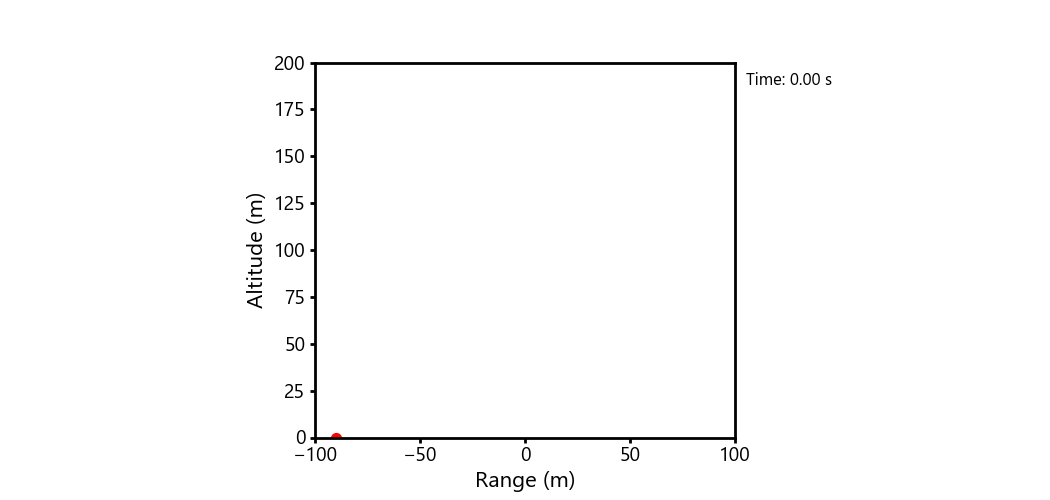

In [3]:
ex.ex_4_2_2()

The next step is to match the new detections with the current set of tracks, so the tracks can be updated. As mentioned above, this step (i.e., mapping detections to tracks) is called *data association*. For scene with lots of targets and/or false alarms, this step can be difficult. More specifically, it can lead to situations like the figure below, which shows the confusion incurred by densely packed detections near the path of a track.

<div style="text-align: center"> <img src="img/data_assoc_prob.png" justify="center" width="550px"></img> </div>

Now that we know which detection goes with which track, we update the state estimates for each track using a *state estimation* algorithm. In short, this fuses the detection information (with its uncertainty information) with the current track state estimates.

<div style="text-align: center"> <img src="img/state_est_prob.png" justify="center" width="850px"></img> </div>

Finally, we go through **track initiation and maintenance**, which decides when to start new tracks and when to end stale tracks. This part of the multitarget tracker loop is very expert-driven, and its logic will vary depending on application.

<div style="text-align: center"> <img src="img/track_init.png" justify="center" width="950px"></img> </div>

In the following, we will study data association and state estimation in more detail.

## Data Association

The main objective of data association is to match new detections with existing tracks; the underlying principle is to *<font color="BlueViolet">the closer a detection is to a predicted target state, the more likely it came from that target</font>*. In the figure below, we can see that there are two new detections along with the predicted track state. The detection close to the predicted position is *highly likely to have originated from the target*; the other detection has a low likelihood of being a target detection.

<div style="text-align: center"> <img src="img/assoc_like.png" justify="center" width="700px"></img> </div>

Things are often not as simple as the figure above: commonly there will be multiple likely detections near a predicted track state or there could be *no* nearby detections. To help solve these issues, there are many data association algorithms developed in the literature. Here are a few:

- **Nearest neighbor**: Greedily associate the nearest detection to each track
    - *Pro*: Extremely simple and fast
    - *Con*: Poor performance in moderately complex scenes
- **Global nearest neighbor**: Find the best way to associate all new detections to tracks to minimize a total distance metric
    - *Pro*: Simple, fast
    - *Con*: Performance degradation in highly complex scenes
- **Multihypothesis tracking**: Perform data association over short history of detections, finding sets of detections to associate to a track
    - *Pro*: Can be resilient in highly complex scenes
    - *Con*: Complex, requires appreciable tuning

In the interactive example below, you can see how nearest neighbor and global nearest neighbor associations compare for different scenes. We can vary the number of *<font color="DarkBlue">Tracks</font>* and *<font color="DarkBlue">Detections</font>* to be used for consideration. Additionally, we can change the *<font color="DarkBlue">Track Accuracy</font>* and *<font color="DarkBlue">Detection Accuracy</font>*; these are illustrated using uncertainty ellipses around the tracks and detections. An uncertainty ellipse shows the area that the target is confidently known to be. Finally, we can see how the tracks and detections are associated using the *<font color="DarkBlue">Nearest</font>* Neighbor and *<font color="DarkBlue">Global Nearest</font>* Neighbor algorithms. Associations are shown as **black** lines between associated tracks and detections. To change parameters and obtain a new scene, click the *<font color="DarkBlue">New</font>* button.

GridBox(children=(VBox(children=(HTML(value="<b><font color='black'>Scene</b>"), FloatSlider(value=10.0, descr…

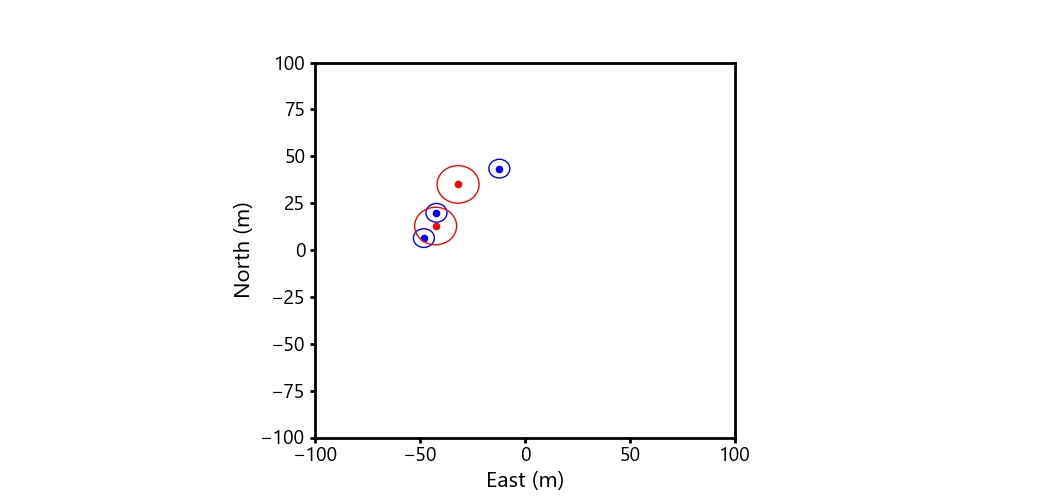

In [4]:
ex.ex_4_2_3()

For an equal number of tracks and detections with good accuracies, the problem can usually be solved quickly by eye; we can notice, however, that as the number of detection versus tracks grow and/or the accuracies degrade, the association problem is not trivial. This is another reason why initial suppression of false alarms is very helpful for a multitarget tracker.

Now, let us assume that we have associated new detections with our current tracks. Next, we should update our state estimates.

## State Estimation

The goal of state estimation is to create an estimate of a target state using a set of detections, where each detection is seen as a measurement of target position (i.e., range, angle) with known accuracies (discussed in [Lab 4.1: Target Parameter Estimation](4_1_Target_Parameter_Estimation.ipynb)). The general flow of a state estimator is given in the following figure:

<div style="text-align: center"> <img src="img/state_est_flow.png" justify="center" width="950px"></img> </div>

The state estimation process iteratively updates using a weighted sum of its current estimate with the incoming detection. The weights are chosen based on the type of expected target motion and the specific state estimation algorithm being used. The following are some common state estimation algorithms:

- **Alpha-beta filters**: Weights are chosen once and fixed for all operation
    - *Pro*: Extremely simple and fast
    - *Con*: Poor performance except for very simple target motion
- **Kalman and extended Kalman filters**: Weights are chosen at each update based on relative uncertainty of current estimate versus detection
    - *Pro*: Simple and fast, works well with many target motions
    - *Con*: Exhibits difficulty with highly complex target motion

The main workhorse for many state estimation processes is the ubiquitous Kalman filter<sup>[[1]](#ref_barshalom)</sup> due to its ease of implementation and flexibility to adapt to many different problems. The extended Kalman filter<sup>[[1]](#ref_barshalom)</sup> (EKF) is a variant of the Kalman filter that allows for target motion models and measurement models that cannot be described as linear functions. We will not get into the math of state estimation for radar but suffice it to say that an EKF is generally required for most radar tracking algorithms. 

In the interactive example below, we can see the output of an EKF over time as it is being fed new detections. More specifically, we are tracking a low-flying target starting due East (estimates will be in the East and North dimensions) and taking radar measurements of the target once every second. The plotted output shows the error of the state estimate as a function of time (in solid **<font color="red">red</font>**) and the uncertainty bounds on the estimate (in dashed **<font color="red">red</font>**). Try changing the radar parameters to see how the detection accuracies change and, subsequently, the state estimates.

GridBox(children=(VBox(children=(HTML(value="<b><font color='black'>Radar</b>"), FloatSlider(value=700.0, desc…

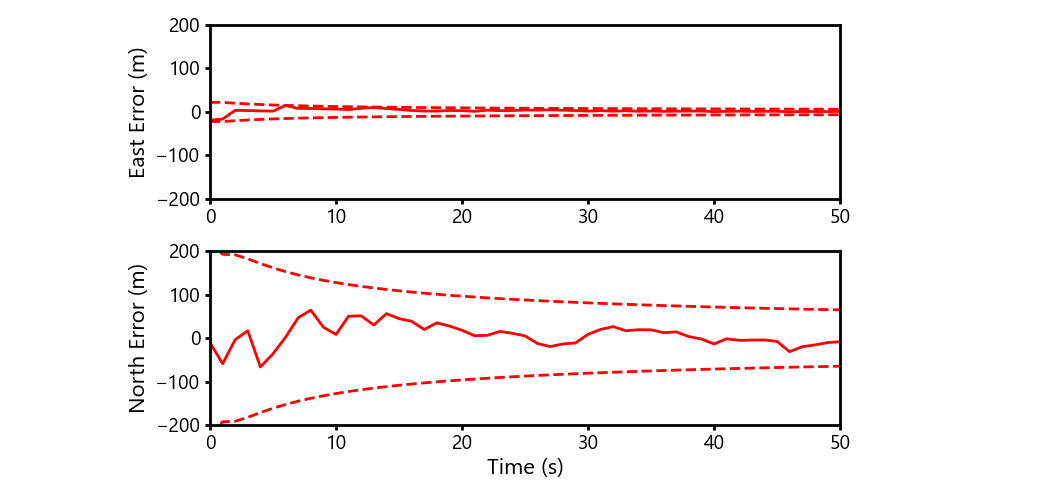

In [5]:
ex.ex_4_2_4()

We can see a few interesting trends:

- The state estimate accuracy improves over time; this is called the **convergence** of a state estimator. This makes intuitive sense as we are getting more information as we observe the target for more time.

- There are many different knobs that affect track accuracy, e.g., dish radius affects: (i) beamwidth, which affects angle measurement accuracy, and (ii) SNR, which affects all parameter estimate accuracies. The more accurate we can make the estimates of range, angle, range rate, etc., the tighter the uncertainty bounds around a track.

- The error in the East dimension is smaller than the error in the North dimension. This is because the target starts due East and, thus, East aligns with our range dimension. Since North is perpendicular to East, it align with our cross-range dimension. Most radar systems (this example included) have much greater accuracy in the range dimension than in the cross-range dimension.

## Tracking

To finish this lab, we will return to Robby to get a feel for the amount of work a multitarget tracker saves a radar operator. In the following interactive example, we will see the output of Robby as multiple targets enter and leave. Press the *<font color="DarkBlue">Scan</font>* button periodically and imagine trying to track the targets by hand; keep in mind what radar parameters would work well. In [Lab 5.1: Radar Design Revisited](5_1_Radar_Design_Revisited.ipynb), we will do hand tracking with a personally designed radar. 

GridBox(children=(VBox(children=(HTML(value="<b><font color='black'>Radar</b>"), FloatSlider(value=1000.0, des…

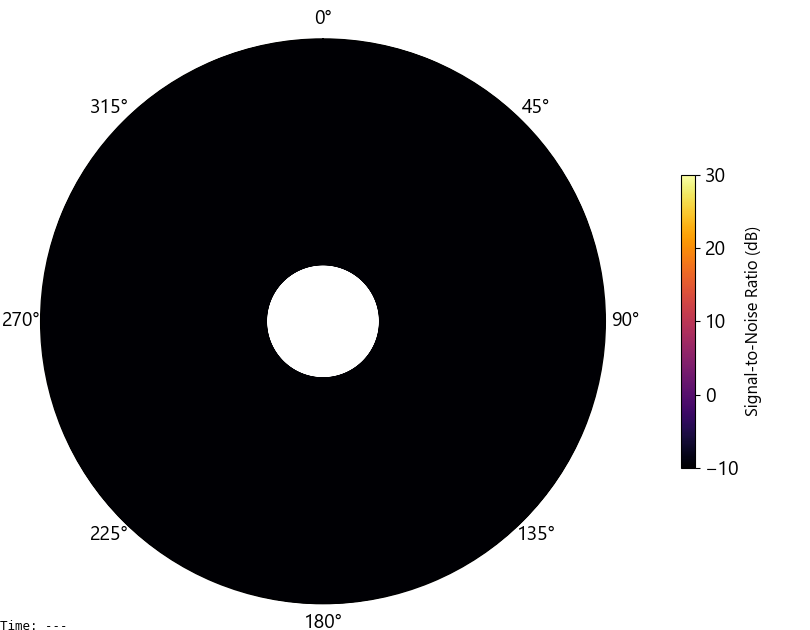

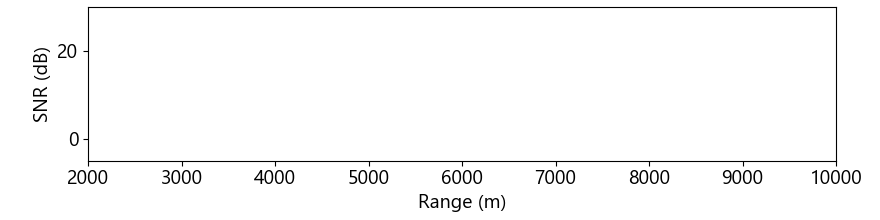

In [6]:
ex.ex_4_2_5()

 ## Summary

In this lab, we studied the subsequent process to detection: multitarget tracking. In this step of the radar processing chain, detections are strung together into object tracks and their states (i.e., summaries of their motion) are estimated. The multitarget tracker is an important part of the radar system as it eliminates false alarms and gives important target position information to the radar control system to allow for further observations of a target. A multitarget tracker typically relies on algorithms for data association (i.e., mapping of new detections to existing tracks) and state estimation (i.e., calculation of estimate of target state from collection of detections). 

## Footnotes

n/a

## References

<a id="ref_barshalom">[1]</a> Y. Bar-Shalom, X. Li, and T. Kirubarajan, *Estimation with Applications to Tracking and Navigation*.
John Wiley & Sons, Inc., 2001.